In [16]:
%pylab inline

import keras.backend as K
from keras import Input, Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.callbacks import *
from keras.losses import *
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints
from keras.models import load_model
from keras.utils import plot_model

import tensorflow as tf
from matplotlib import pyplot as plt

from datetime import datetime
from pathlib import Path

import pickle
import gc

Populating the interactive namespace from numpy and matplotlib


/home/ing-luca/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['minimum', 'datetime', 'average', 'maximum', 'copy', 'subtract', 'concatenate', 'get', 'poisson', 'dot', 'add', 'multiply']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
def split_data(dataset, timesteps):
    D = dataset.shape[1]
    if D < timesteps:
        return None
    elif D == timesteps:
        return dataset
    else:
        splitted_data, remaining_data = np.hsplit(dataset, [timesteps])
        remaining_data = split_data(remaining_data, timesteps)
        if remaining_data is not None:
            return np.vstack([splitted_data, remaining_data])
        return splitted_data

In [46]:
class VAE:
    def __init__(self, timesteps, batch_size, latent_dim,
                 run_dir, img_dir, model_dir, generated_datesets_dir):
        self._timesteps = timesteps
        self._batch_size = batch_size
        self._latent_dim = latent_dim
        self._run_dir = run_dir
        self._img_dir = img_dir
        self._model_dir = model_dir
        self._generated_datesets_dir = generated_datesets_dir
        
        self._save_config()

    def build_models(self, lr):  
        def _sampling(args):
            encoded_mean, encoded_log_var = args
            epsilon = K.random_normal(shape=(self._batch_size, self._latent_dim), mean=0., stddev=1.0)
            return encoded_mean + K.exp(encoded_log_var/2.0) * epsilon
        
        inputs = Input((self._timesteps,))
        z = Input((self._latent_dim,))

        encoded = inputs
        encoded = Lambda(lambda x: K.expand_dims(x))(
            encoded)
        while encoded.shape[1] > 1:
            encoded = Conv1D(
                32, 3, activation='tanh', padding='same')(encoded)
            encoded = MaxPooling1D(2, padding='same')(encoded)
        encoded = Flatten()(encoded)
        encoded = Dense(32, activation='tanh')(encoded)
        z_mean = Dense(latent_dim)(encoded)
        z_log_var = Dense(latent_dim)(encoded) 
        
        self._encoder = Model(inputs, z_mean)
        
        sampled_z = Lambda(self._sampling)([z_mean, z_log_var])

        decoder_inputs = Input((latent_dim, ))
        decoded = decoder_inputs

        decoded = Lambda(lambda x: K.expand_dims(x))(decoded)
        while decoded.shape[1] < timesteps:
            decoded = Conv1D(
                32, 3, activation='tanh', padding='same')(decoded)
            decoded = UpSampling1D(2)(decoded)
        decoded = Conv1D(
            1, 3, activation='tanh', padding='same')(decoded)
        decoded = Lambda(lambda x: K.squeeze(x, -1))(decoded)
        decoded = Dense(self._timesteps, activation='sigmoid')(decoded)
        
        decoder = Model(decoder_inputs, decoded)
        
        decoded_inputs = decoder(sampled_z)
        
        def vae_loss(y_true, y_pred):
            xent_loss = self._timesteps * binary_crossentropy(y_true, y_pred)
            kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            vae_loss = K.mean(xent_loss + 0.1 * kl_loss)
            return vae_loss
        
        self._vae = Model(inputs, decoded_inputs)
        self._vae.compile(optimizer='rmsprop', loss=vae_loss)

        self._generator = Model(z, decoder(z))
        
#         (self._encoded_mean, self._encoded_log_var) = self._build_encoder(self._latent_dim, self._timesteps)(inputs)
#         sampled_z = Lambda(self._sampling)([self._encoded_mean, self._encoded_log_var])
        
#         decoder = self._build_decoder(self._latent_dim, self._timesteps)
#         decoded_inputs = decoder(sampled_z)

#         self._vae = Model(inputs, decoded_inputs)
#         self._vae.compile(optimizer='rmsprop', loss=self._vae_loss)

#         self._generator = Model(z, decoder(z))
#         self._encoder = Model(inputs, self._encoded_mean)
        return self._vae, self._generator, self._encoder

    def _build_decoder(self, latent_dim, timesteps):
        decoder_inputs = Input((latent_dim, ))
        decoded = decoder_inputs

        decoded = Lambda(lambda x: K.expand_dims(x))(decoded)
        while decoded.shape[1] < timesteps:
            decoded = Conv1D(
                32, 3, activation='relu', padding='same')(decoded)
            decoded = UpSampling1D(2)(decoded)
        decoded = Conv1D(
            1, 3, activation='relu', padding='same')(decoded)
        decoded = Lambda(lambda x: K.squeeze(x, -1))(decoded)
        decoded = Dense(timesteps, activation='sigmoid')(decoded)

        decoder = Model(decoder_inputs, decoded)
        return decoder

    def _build_encoder(self, latent_dim, timesteps):
        encoder_inputs = Input((timesteps, ))
        encoded = encoder_inputs
        
        encoded = Lambda(lambda x: K.expand_dims(x))(
            encoded)
        while encoded.shape[1] > 1:
            encoded = Conv1D(
                32, 3, activation='relu', padding='same')(encoded)
            encoded = MaxPooling1D(2, padding='same')(encoded)
        encoded = Flatten()(encoded)
        z_mean = Dense(latent_dim)(encoded)
        z_log_var = Dense(latent_dim)(encoded) 
        
        return (z_mean, z_log_var)

    def train(self, batch_size, epochs, dataset, img_frequency, model_save_frequency, dataset_generation_frequency, dataset_generation_size):
        losses = [[], []]
        
        for epoch in range(epochs):
            self._vae.fit(dataset, dataset, batch_size=batch_size)
            
            if epoch % img_frequency == 0:
                self._save_imgs(epoch)
            if epoch % model_save_frequency == 0:
                self._save_models()
            if epoch % dataset_generation_frequency == 0:
                self._generate_dataset(dataset_generation_size)
            if epoch % img_frequency == 0:
                transactions_encoded = encoder.predict(dataset, batch_size=batch_size)
                plt.figure(figsize=(6, 6))
                plt.scatter(transactions_encoded[:, 0], transactions_encoded[:, 1])
                plt.savefig(str(self._img_dir / ('latent_space_%05d.png' % epoch)))
        
    def _save_imgs(self, epoch):
        rows, columns = 5, 5
        noise = np.random.normal(0, 1, (rows * columns, latent_dim))
        generated_samples = self._generator.predict(noise)

        plt.subplots(rows, columns, figsize=(15, 5))
        k = 1
        for i in range(rows):
            for j in range(columns):
                plt.subplot(rows, columns, k)
                plt.plot(generated_samples[k - 1])
                plt.xticks([])
                plt.yticks([])
                plt.ylim(-1, 1)
                k += 1
        plt.tight_layout()
        plt.savefig(str(self._img_dir / ('%05d.png' % epoch)))
        plt.savefig(str(self._img_dir / 'last.png'))
        plt.close()

    def _save_losses(self, losses):
        plt.plot(losses[0])
        plt.plot(losses[1])
        plt.legend(['generator', 'critic'])
        plt.savefig(str(self._img_dir / 'losses.png'))
        plt.close()

    def _save_config(self):
        config = {
            'timesteps' : self._timesteps,
            'latent_dim' : self._latent_dim,
            'run_dir' : self._run_dir,
            'img_dir' : self._img_dir,
            'model_dir' : self._model_dir,
            'generated_datesets_dir' : self._generated_datesets_dir
        }
        
        with open(str(self._run_dir / 'config.p'), 'wb') as f:
            pickle.dump(config, f)
        
    def _save_models(self):
        self._vae.save(self._model_dir / 'vae.h5')
        self._generator.save(self._model_dir / 'generator.h5')
        self._encoder.save(self._model_dir / 'encoder.h5')
        
    def _generate_dataset(self, epoch, dataset_generation_size):
        z_samples = np.random.normal(0, 1, (dataset_generation_size, self._latent_dim))
        generated_dataset = self._generator.predict(z_samples)
        np.save(self._generated_datesets_dir / ('%d_generated_data' % epoch), generated_dataset)
        np.save(self._generated_datesets_dir / 'last', generated_dataset)
        
    def get_models(self):
        return self._gan, self._generator, self._critic

    def load_models(self):
        self._gan = load_model(self._model_dir / 'wgan.h5')
        self._generator = load_model(self._model_dir / 'generator.h5')
        self._critic = load_model(self._model_dir / 'critic.h5')
        


In [47]:
normalized_transactions_filepath = "../datasets/berka_dataset/usable/normalized_transactions.npy"

timesteps = 100
transactions = np.load(normalized_transactions_filepath)
transactions = split_data(transactions, timesteps)
transactions = transactions[np.std(transactions, 1) > float(1e-7)][:53500, :]
transactions = (transactions + 1.0) / 2.0
N, D = transactions.shape
print(transactions.shape)

(53500, 100)


In [31]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)/255.0
x_train = x_train[:50000]
timesteps = 784
transactions = x_train
print(transactions.shape)

(50000, 784)


In [48]:
batch_size = 25
epochs = 50000
latent_dim = 2
lr = 0.0001

img_frequency = 250
model_save_frequency = 3000
dataset_generation_frequency = 25000
dataset_generation_size = 100000

In [49]:
root_path = Path('vae')
if not root_path.exists():
    root_path.mkdir()
    
current_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

run_dir = root_path / current_datetime
img_dir = run_dir / 'img'
model_dir = run_dir / 'models'
generated_datesets_dir = run_dir / 'generated_datasets'

img_dir.mkdir(parents=True)
model_dir.mkdir(parents=True)
generated_datesets_dir.mkdir(parents=True)

Epoch 1/1
53500/53500 [==============================] - 20s 378us/step - loss: 66.6588
6.331126e-05


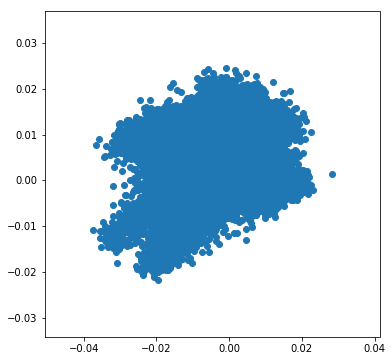

Epoch 1/1
53500/53500 [==============================] - 19s 358us/step - loss: 66.6411
1.0005193e-05


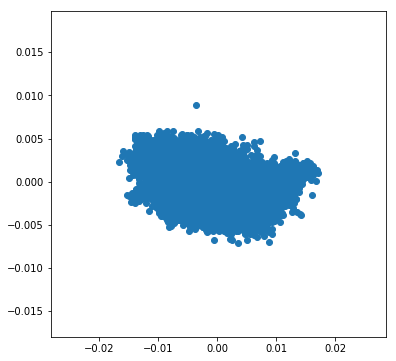

Epoch 1/1
53500/53500 [==============================] - 19s 361us/step - loss: 66.6388
1.0271108e-05


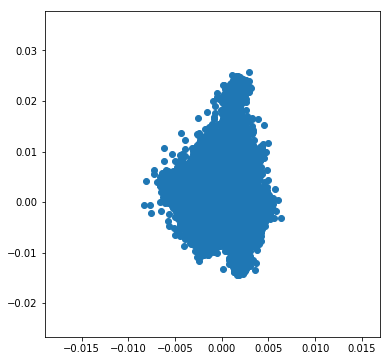

Epoch 1/1
53500/53500 [==============================] - 20s 367us/step - loss: 66.6386
1.2249972e-05


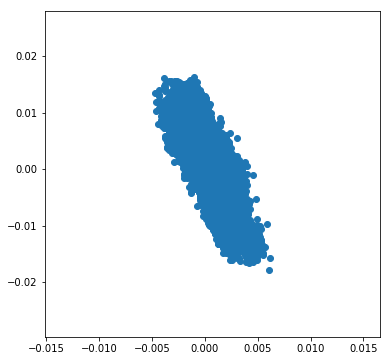

Epoch 1/1
53500/53500 [==============================] - 20s 373us/step - loss: 66.6386
9.798607e-07


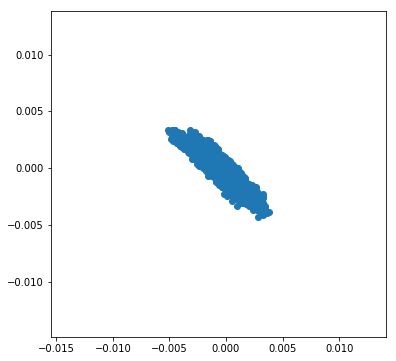

Epoch 1/1
53500/53500 [==============================] - 19s 362us/step - loss: 66.6388
5.620484e-07


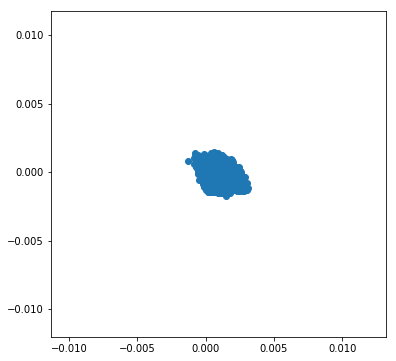

Epoch 1/1
53500/53500 [==============================] - 19s 358us/step - loss: 66.6392
2.0493128e-06


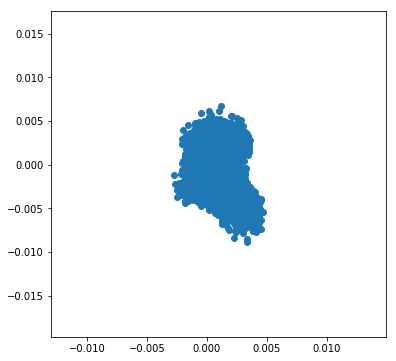

Epoch 1/1
53500/53500 [==============================] - 20s 367us/step - loss: 66.6392
6.2012505e-06


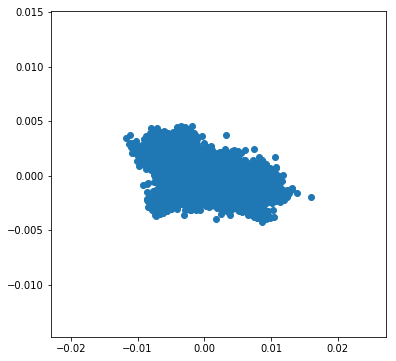

Epoch 1/1
53500/53500 [==============================] - 19s 359us/step - loss: 66.6393
5.1061816e-06


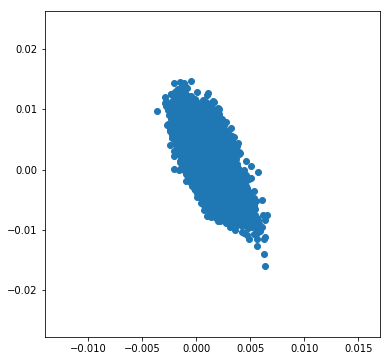

Epoch 1/1
53500/53500 [==============================] - 19s 364us/step - loss: 66.6391
8.693027e-06


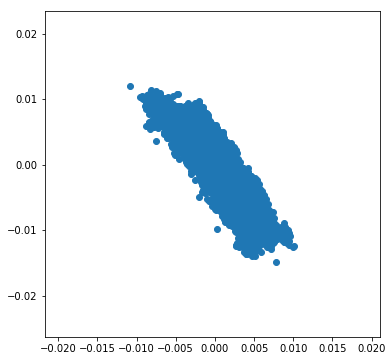

Epoch 1/1
53500/53500 [==============================] - 19s 364us/step - loss: 66.6386
3.1461397e-07


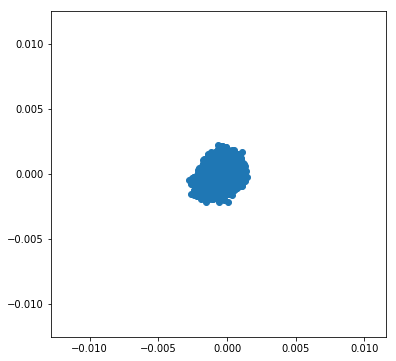

Epoch 1/1
53500/53500 [==============================] - 19s 358us/step - loss: 66.6378
2.4518813e-06


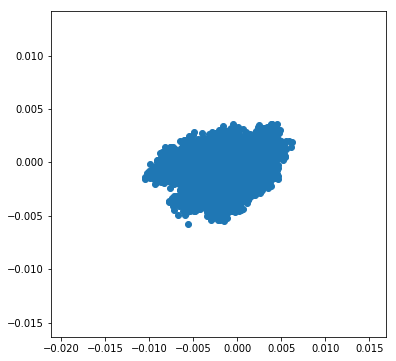

Epoch 1/1
53500/53500 [==============================] - 19s 362us/step - loss: 66.6364
3.381927e-06


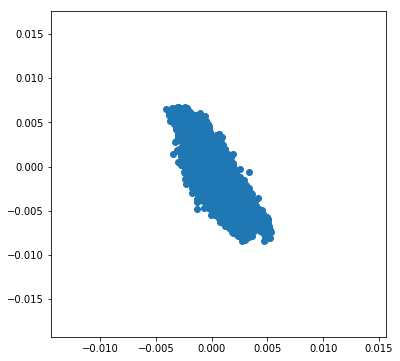

Epoch 1/1
53500/53500 [==============================] - 20s 366us/step - loss: 66.6360
9.465009e-05


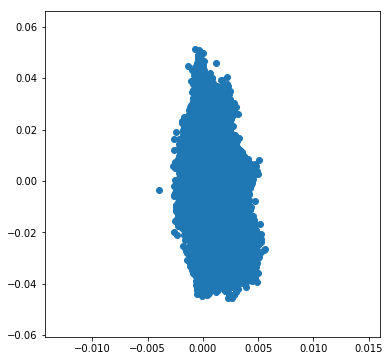

Epoch 1/1
53500/53500 [==============================] - 20s 366us/step - loss: 66.6360
2.7866213e-06


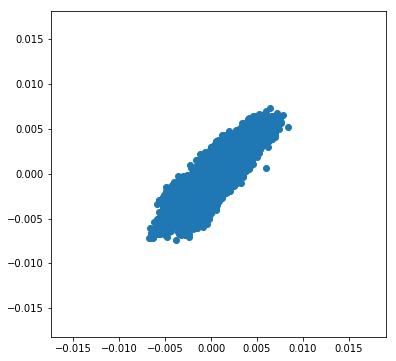

Epoch 1/1
53500/53500 [==============================] - 20s 370us/step - loss: 66.6360
4.5270198e-07


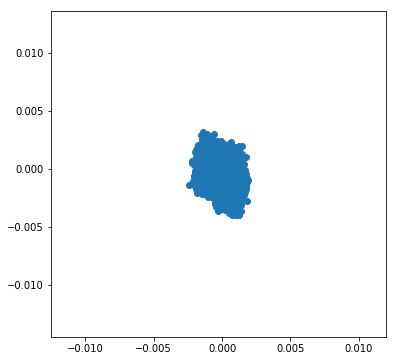

Epoch 1/1
53500/53500 [==============================] - 20s 372us/step - loss: 66.6361
1.2489046e-07


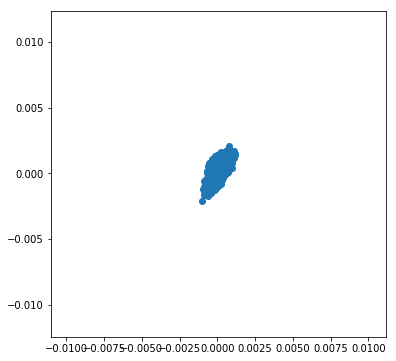

Epoch 1/1
53500/53500 [==============================] - 20s 365us/step - loss: 66.6360
1.1685735e-07


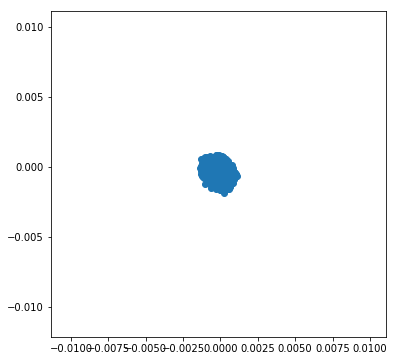

Epoch 1/1
53500/53500 [==============================] - 20s 365us/step - loss: 66.6361
0.00023870016


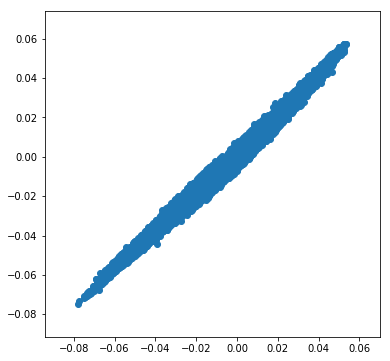

Epoch 1/1
53500/53500 [==============================] - 20s 366us/step - loss: 66.6360
6.471956e-07


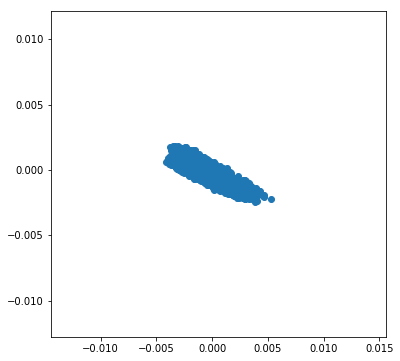

Epoch 1/1
53500/53500 [==============================] - 19s 363us/step - loss: 66.6361
2.1047566e-07


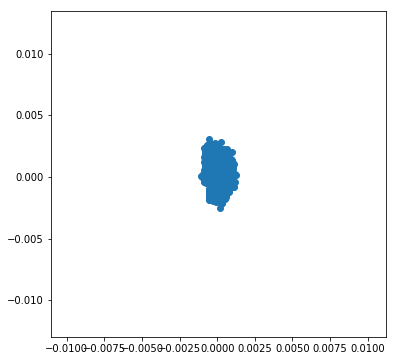

Epoch 1/1
53500/53500 [==============================] - 20s 372us/step - loss: 66.6361
4.6293455e-05


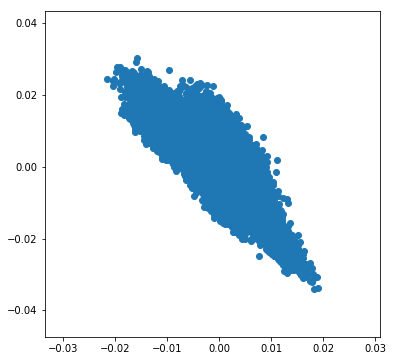

Epoch 1/1
53500/53500 [==============================] - 20s 368us/step - loss: 66.6361
1.0052688e-05


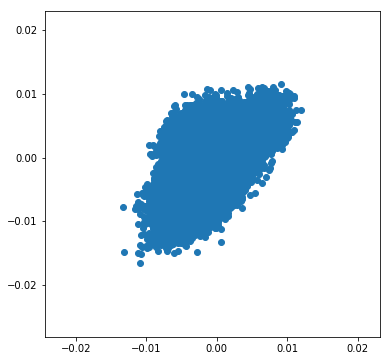

Epoch 1/1
53500/53500 [==============================] - 20s 366us/step - loss: 66.6361
1.2641485e-06


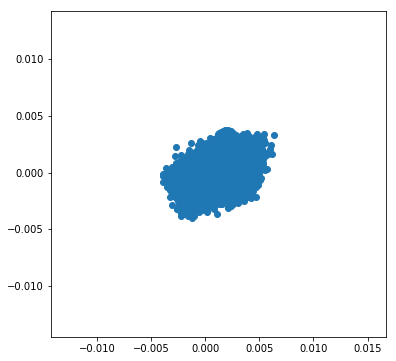

Epoch 1/1
53500/53500 [==============================] - 19s 364us/step - loss: 66.6360
1.6814839e-07


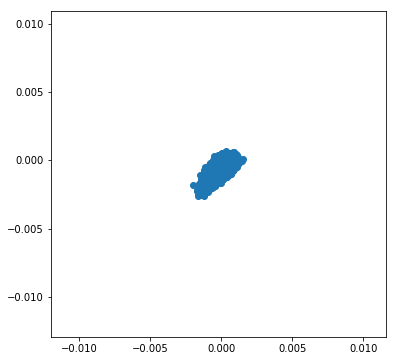

Epoch 1/1
53500/53500 [==============================] - 20s 372us/step - loss: 66.6360
2.5056159e-05


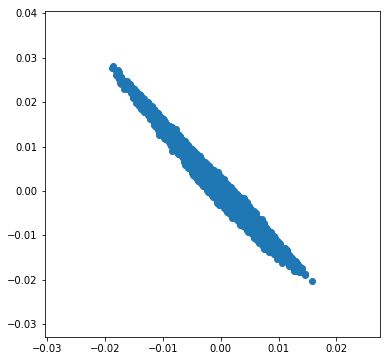

Epoch 1/1
53500/53500 [==============================] - 20s 368us/step - loss: 66.6361
5.1590032e-05


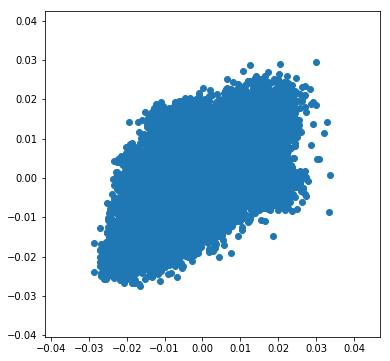

Epoch 1/1
53500/53500 [==============================] - 20s 367us/step - loss: 66.6361
2.5449071e-05


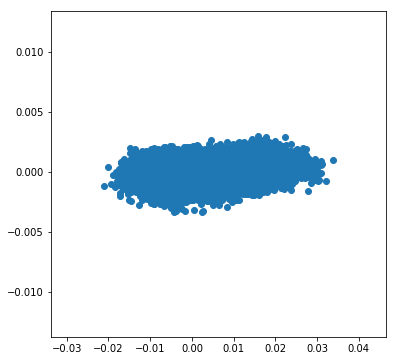

Epoch 1/1
53500/53500 [==============================] - 20s 379us/step - loss: 66.6360
8.732435e-06


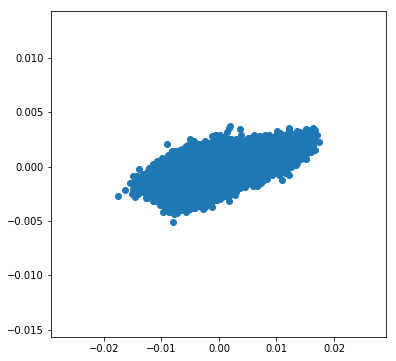

Epoch 1/1
11775/53500 [=====>........................] - ETA: 15s - loss: 66.6310

KeyboardInterrupt: 

In [50]:
vae = VAE(timesteps, batch_size, latent_dim, run_dir, img_dir, model_dir, generated_datesets_dir)
vae_model, generator, encoder = vae.build_models(lr)

# gan.summary()
# generator.summary()
# critic.summary()

losses = vae.train(batch_size, epochs, transactions, img_frequency, model_save_frequency, dataset_generation_frequency, dataset_generation_size)

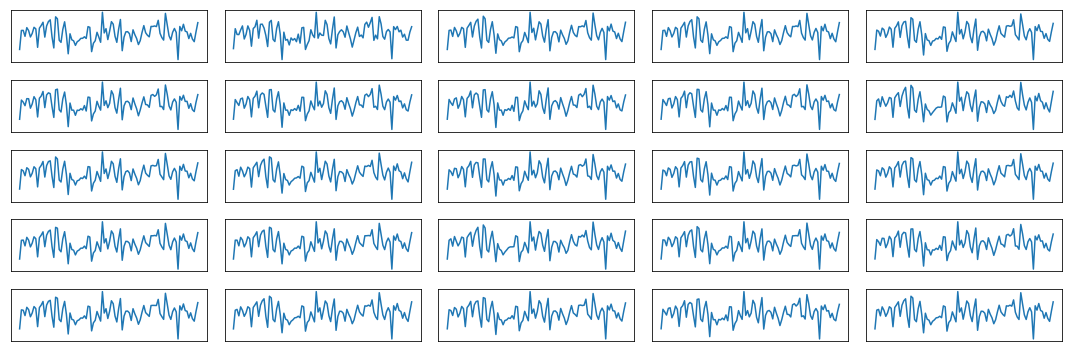

In [51]:
rows, columns = 5, 5
noise = np.random.normal(0, 1, (rows * columns, latent_dim))
generated_samples = generator.predict(noise)

plt.subplots(rows, columns, figsize=(15, 5))
k = 1
for i in range(rows):
    for j in range(columns):
        plt.subplot(rows, columns, k)
        plt.plot(generated_samples[k - 1])
        plt.xticks([])
        plt.yticks([])
        k += 1
plt.tight_layout()
plt.show()